# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly 
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import make_scorer, log_loss

from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

import warnings
import random

warnings.filterwarnings('ignore')

import glob

# 경로 설정
import os, sys
os.chdir('C:/dacon camp/credit_card')

# 옵션 설정
pd.set_option('display.max_columns', None)
matplotlib.rc('font', family='New Gulim') # 한글 설정
matplotlib.rc('axes', unicode_minus=False) # 음수 부호 깨지는거 설정

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 50)

# Data Loading

In [3]:
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

display('train', train_raw.shape)
display('test', test_raw.shape)

'train'

(26457, 20)

'test'

(10000, 19)

# EDA

In [4]:
display('train', train_raw.head())
display('test', test_raw.head())

'train'

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


'test'

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


- index 변수는 필요없으므로 삭제해줍시다.

In [5]:
df_train = train_raw.drop(['index'], axis=1)
df_test = test_raw.drop(['index'], axis=1)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         10000 non-null  object 
 1   car            10000 non-null  object 
 2   reality        10000 non-null  object 
 3   child_num      10000 non-null  int64  
 4   income_total   10000 non-null  float64
 5   income_type    10000 non-null  object 
 6   edu_type       10000 non-null  object 
 7   family_type    10000 non-null  object 
 8   house_type     10000 non-null  object 
 9   DAYS_BIRTH     10000 non-null  int64  
 10  DAYS_EMPLOYED  10000 non-null  int64  
 11  FLAG_MOBIL     10000 non-null  int64  
 12  work_phone     10000 non-null  int64  
 13  phone          10000 non-null  int64  
 14  email          10000 non-null  int64  
 15  occyp_type     6848 non-null   object 
 16  family_size    10000 non-null  float64
 17  begin_month    10000 non-null  float64
dtypes: floa

## 결측치 확인 및 처리

<AxesSubplot:>

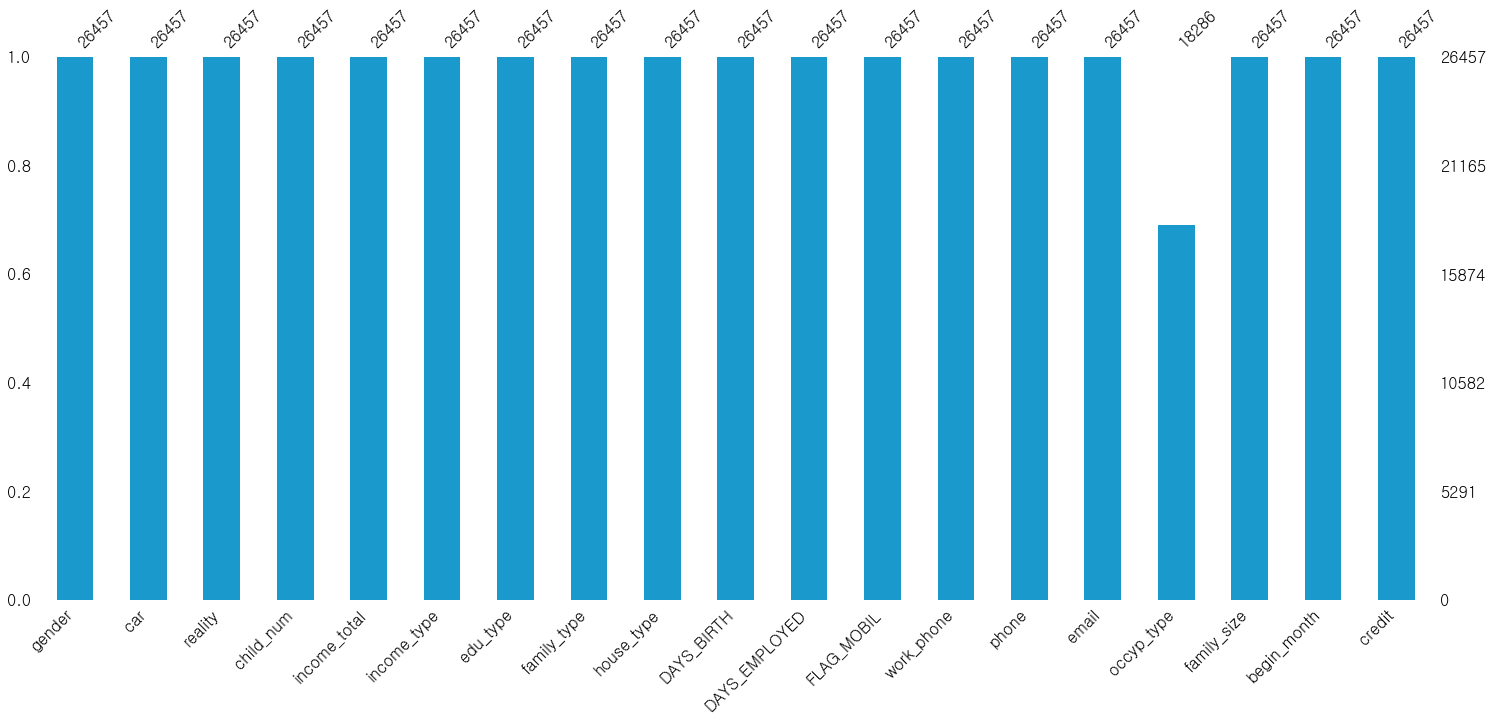

In [8]:
import missingno as msno

# train data의 결측치
msno.bar(df=df_train.iloc[:, :], color=(0.1, 0.6, 0.8))

<AxesSubplot:>

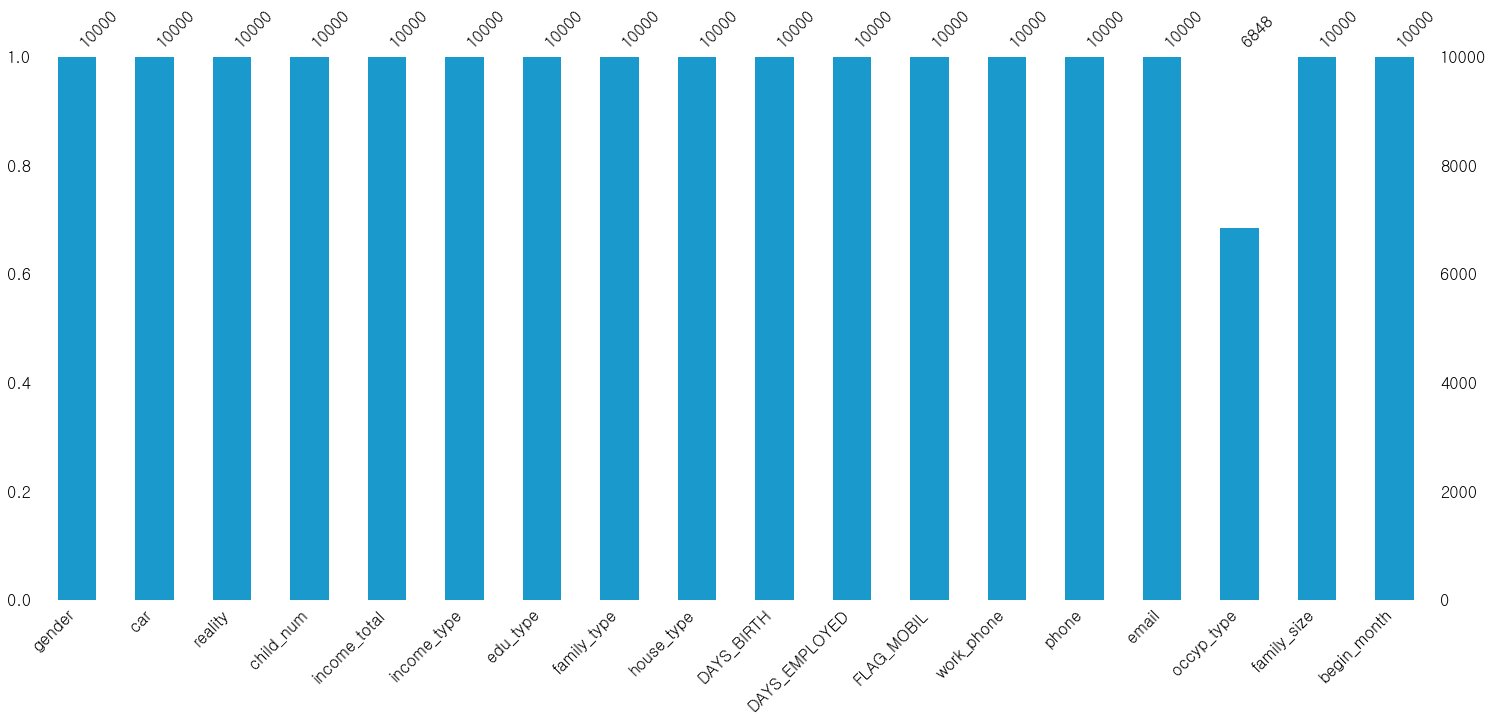

In [9]:
msno.bar(df=df_test.iloc[:, :], color=(0.1, 0.6, 0.8))

- Train, Test 데이터 모두에서 직업 유형 변수에서만 결측치가 존재합니다.
- 변수명의 특성상, 직업이 없기 때문에 결측값이 발생한 것이라 생각되어 No_job(직업 없음)으로 채워줍니다.

In [10]:
df_train.loc[df_train['occyp_type'].isnull(), 'occyp_type'] = 'no_job'
df_test.loc[df_test['occyp_type'].isnull(), 'occyp_type'] = 'no_job'

## 신용등급 분포 확인

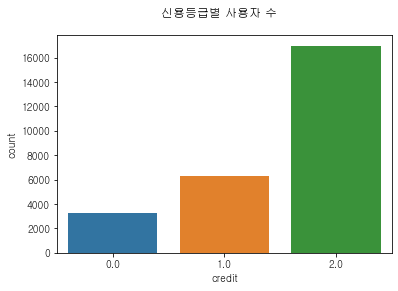

In [11]:
fig, ax = plt.subplots()
sns.countplot(data=df_train, x='credit')
fig.suptitle('신용등급별 사용자 수')
plt.show()

- credit의 수치는 낮을수록 높은 신용의 신용카드 사용자를 의미하는데, 낮은 신용의 신용카드 사용자가 많은 것을 볼 수 있습니다.
- credit에 따른 그룹을 나누어 각 변수를 비교 분석 한다면, 유의미한 변수를 발견할 수 있을 거라고 생각합니다.

## 범주형 변수에 대한 EDA

In [12]:
df_train_0 = df_train[df_train['credit'] == 0]
df_train_1 = df_train[df_train['credit'] == 1]
df_train_2 = df_train[df_train['credit'] == 2]

display(df_train_0.shape)
display(df_train_1.shape)
display(df_train_2.shape)

(3222, 19)

(6267, 19)

(16968, 19)

In [13]:
# Categorical 그래프 함수 정의 
# 참고 : https://dacon.io/competitions/official/235713/codeshare/2519?page=3&dtype=recent
def cat_plot(column):

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))


  sns.countplot(x = column,
                data = df_train_0,
                ax = ax[0],
                order = df_train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = df_train_1,
                ax = ax[1],
                order = df_train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = df_train_2,
                ax = ax[2],
                order = df_train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.suptitle(column, fontsize=15)
  plt.subplots_adjust(wspace=0.3, hspace=0.5)
  plt.show()

In [14]:
obj_cols = list(df_train.select_dtypes('object').columns)
obj_cols

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [15]:
def ratio_by_group(column):
    temp_0 = pd.DataFrame(df_train_0[column].value_counts()).reset_index()
    temp_0['ratio'] = temp_0[column] / temp_0[column].sum()
    temp_0['type'] = '0'
    
    temp_1 = pd.DataFrame(df_train_1[column].value_counts()).reset_index()
    temp_1['ratio'] = temp_1[column] / temp_1[column].sum()
    temp_1['type'] = '1'

    temp_2 = pd.DataFrame(df_train_2[column].value_counts()).reset_index()
    temp_2['ratio'] = temp_2[column] / temp_2[column].sum()
    temp_2['type'] = '2'
    
    temp = pd.concat([temp_0, temp_1, temp_2], axis=0)
    
    return temp

In [16]:
# 신용등급별 변수의 비율을 나타내는 그래프
def ratio_pie(data, column):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (16,10))
    bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일

    ## annotation 설정
    config = dict(arrowprops=dict(arrowstyle='-'),bbox=bbox_props,va='center')

    for i in range(3):    
        frequency = data[data['type'] == str(i)][column]
        labels = list(data[data['type'] == str(i)]['index'].unique())
        total = np.sum(frequency)
        threshold = 5 ## 상한선 비율
        sum_pct = 0 ## 퍼센티지
        
        pie = ax[i].pie(frequency, ## 파이차트 출력
           startangle=90, ## 시작점을 90도(degree)로 지정
           counterclock=False, ## 시계방향으로 그려짐
           explode = [0.05]*len(labels),
       )
        
        ax[i].set_title(f'credit = {i}')

        for j,l in enumerate(labels):
            ang1, ang2 = ax[i].patches[j].theta1, ax[i].patches[j].theta2 ## 파이의 시작 각도와 끝 각도
            center, r = ax[i].patches[j].center, ax[i].patches[j].r ## 원의 중심 좌표와 반지름길이

            if j < len(labels) - 1:
                sum_pct += float(f'{frequency[j]/total*100:.2f}')
                text = f'{frequency[j]/total*100:.2f}%'
            else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
                text = f'{100-sum_pct:.2f}%'

            ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
            if frequency[j]/total*100 < threshold:
                ang = (ang1+ang2)/2 ## 중심각
                x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
                y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표

                ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
                ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
                horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
                connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
                config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
                ax[i].annotate(text, xy=(x, y), xytext=(1.5*x, 1.2*y),
                            horizontalalignment=horizontalalignment, **config)
            else:
                x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
                y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
                ax[i].text(x,y,text,ha='center',va='center',fontsize=12)
    
        plt.legend(pie[0],labels,loc='upper right', bbox_to_anchor=(1.0,1.0,0.5,0.5)) ## 범례
    fig.suptitle(f'{column}', y = 0.8, fontsize=20)
    plt.show()

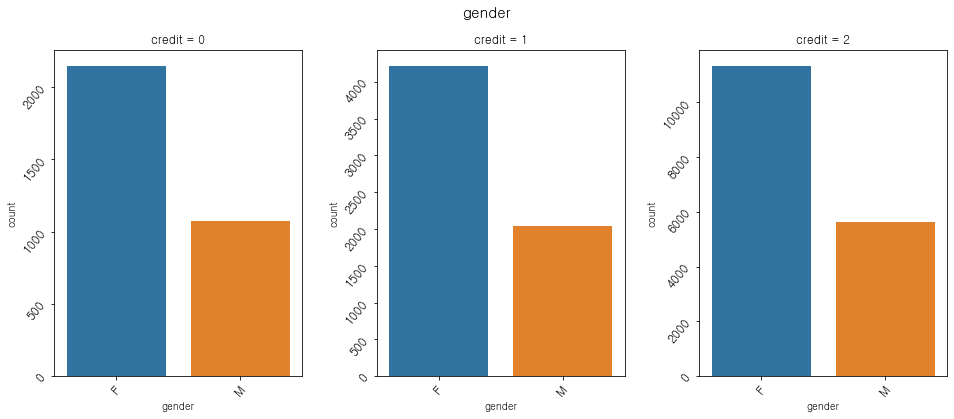

In [17]:
cat_plot(obj_cols[0])

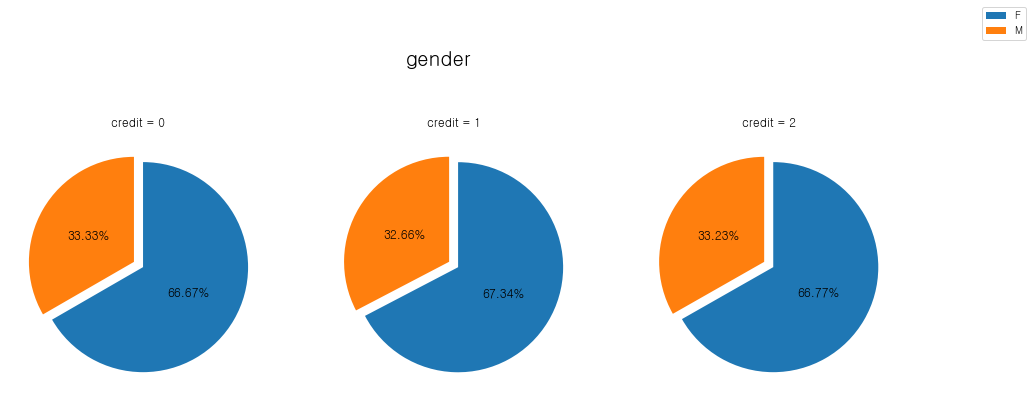

In [18]:
ratio_pie(ratio_by_group(obj_cols[0]), obj_cols[0])

- 모든 등급에서 여성이 남성보다 더 많은 것을 볼 수 있습니다.

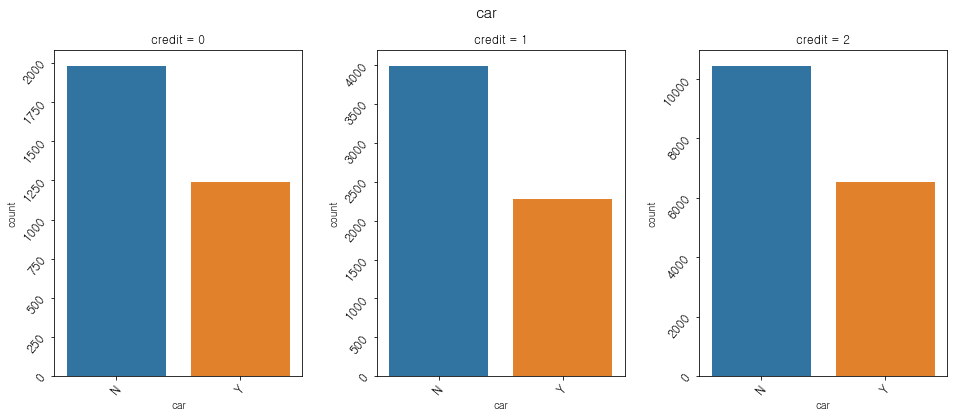

In [19]:
cat_plot(obj_cols[1])

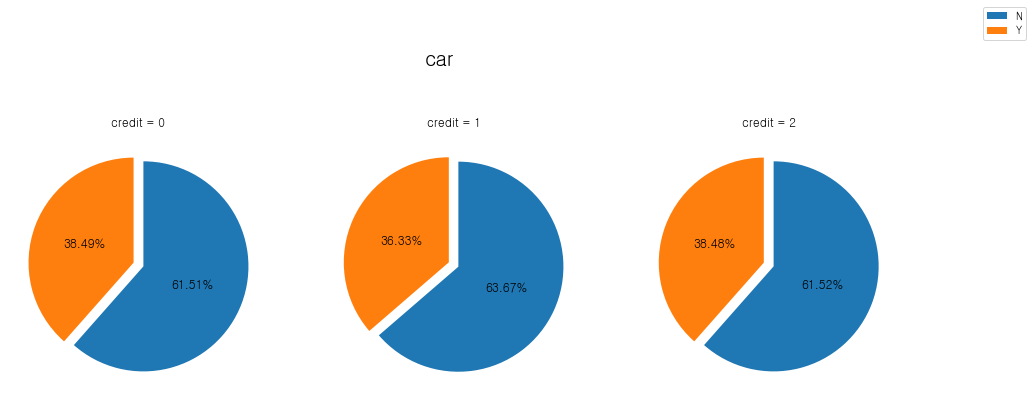

In [20]:
ratio_pie(ratio_by_group(obj_cols[1]), obj_cols[1])

- 모든 신용 등급에서 차를 소유하지 않은 사람이 소유한 사람보다 많은 것을 볼 수 있습니다.
- 실제 차량 소유 여부의 비율을 살펴보아도, 신용등급이 2인 사람과 0인 사람의 차이는 거의 나지 않는 것을 볼 수 있습니다.

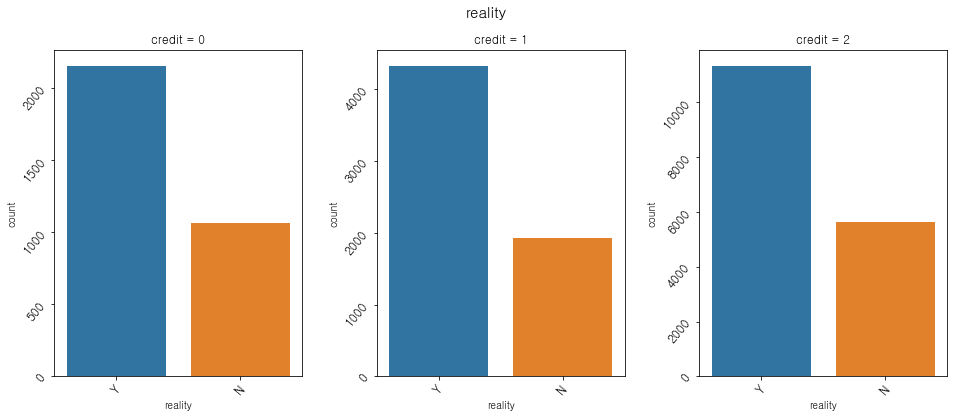

In [21]:
cat_plot(obj_cols[2])

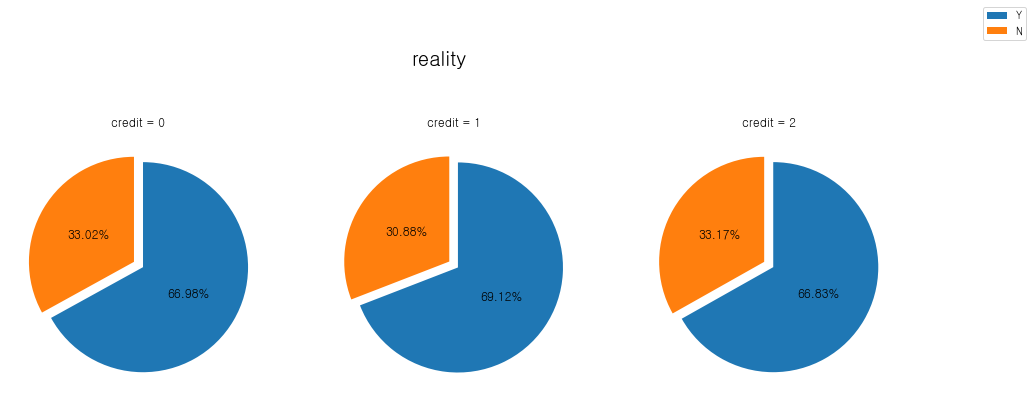

In [22]:
ratio_pie(ratio_by_group(obj_cols[2]), obj_cols[2])

- 신용등급별 부동산 소유 여부를 비교해보았을 때, 모두 비슷한 분포를 보이지만, 신용등급이 1인 경우에 부동산 소유 비율이 가장 높은 것을 확인할 수 있습니다.

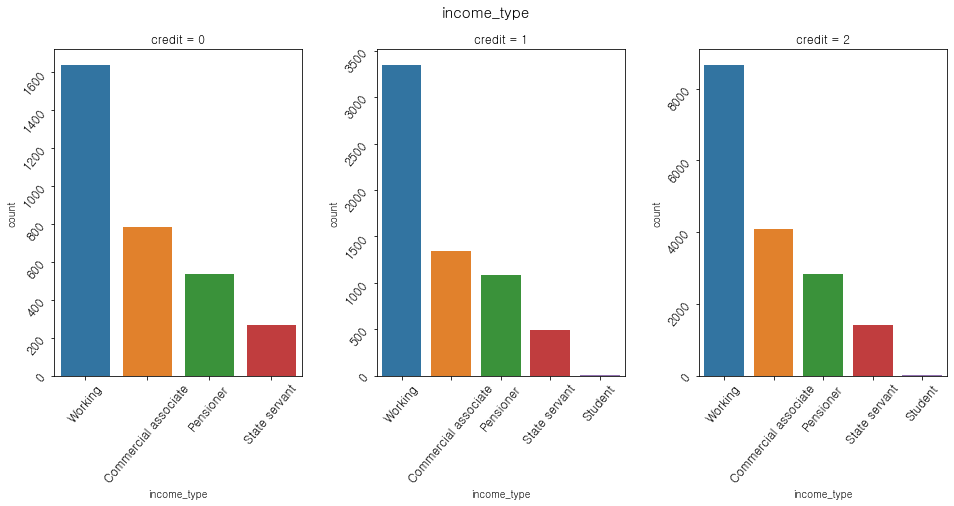

In [23]:
cat_plot(obj_cols[3])

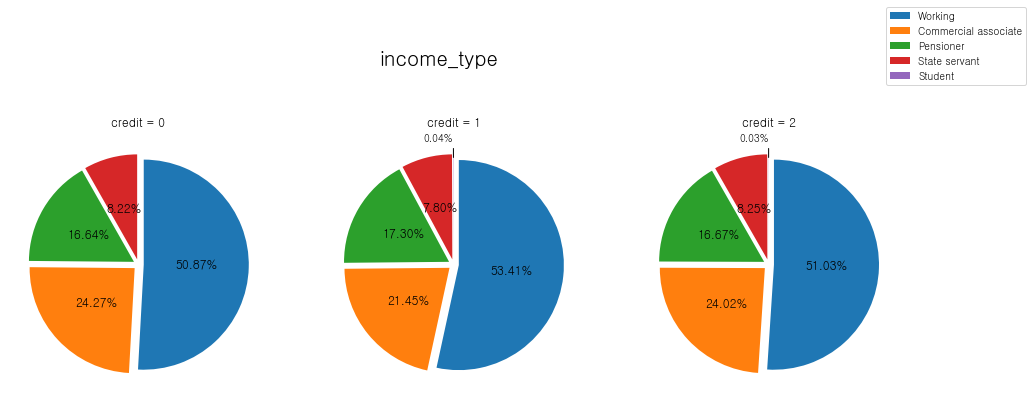

In [24]:
ratio_pie(ratio_by_group(obj_cols[3]), obj_cols[3])

- 높은 신용 등급에는 학생이 존재하지 않는 것을 볼 수 있습니다.
- 학생은 소득이 없기 때문이지 않을까라는 생각을 할 수 있습니다.
- 신용등급이 0인 경우와 2인 경우는 비슷한 분포를 띕니다.
- 신용등급이 1인 경우에는 Working의 비중과 Pensioner의 비중이 다른 두 집단에 비해 조금 더 높은 것을 볼 수 있다. 반면, Commercial associate의 비중은 조금 더 낮습니다.

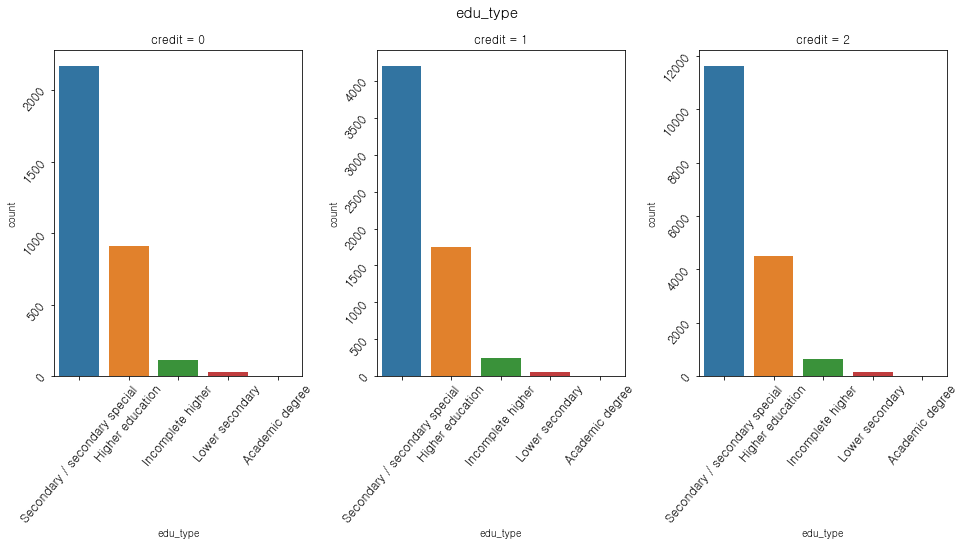

In [25]:
cat_plot(obj_cols[4])

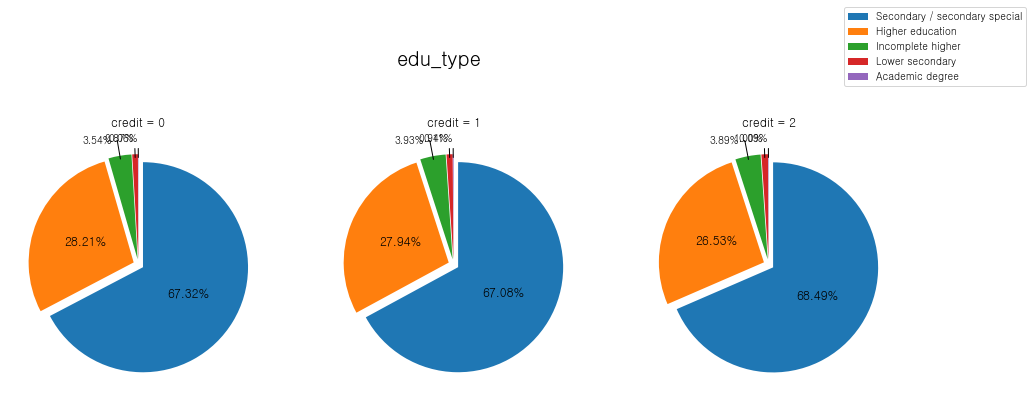

In [26]:
ratio_pie(ratio_by_group(obj_cols[4]), obj_cols[4])

In [27]:
ratio_by_group(obj_cols[4])

,index,edu_type,ratio,type
0,Secondary / secondary special,2169,0.673184,0
1,Higher education,909,0.282123,0
2,Incomplete higher,114,0.035382,0
3,Lower secondary,28,0.008690,0
4,Academic degree,2,0.000621,0
0,Secondary / secondary special,4204,0.670815,1
1,Higher education,1751,0.279400,1
2,Incomplete higher,246,0.039253,1
3,Lower secondary,59,0.009414,1
4,Academic degree,7,0.001117,1


- 모든 신용등급에서 교육수준의 순위는 같았고 각 그룹별 교육수준의 비율도 비슷합니다.

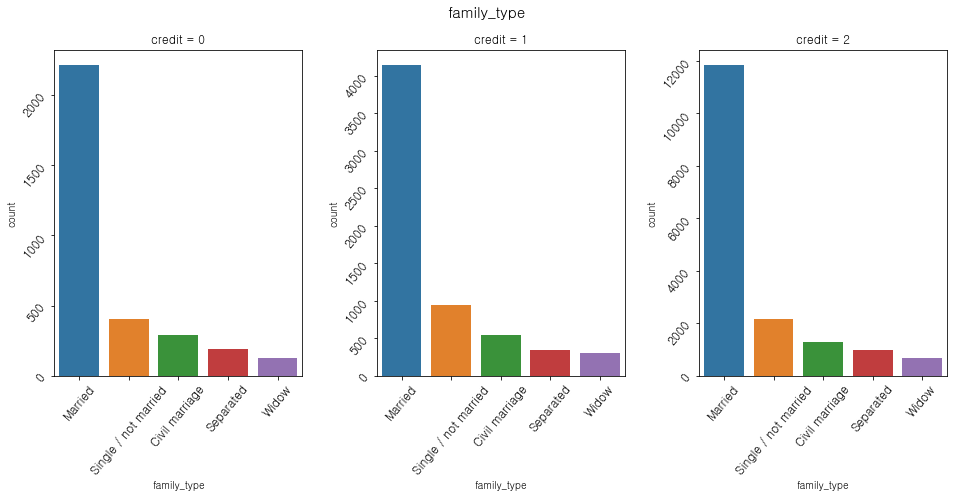

In [28]:
cat_plot(obj_cols[5])

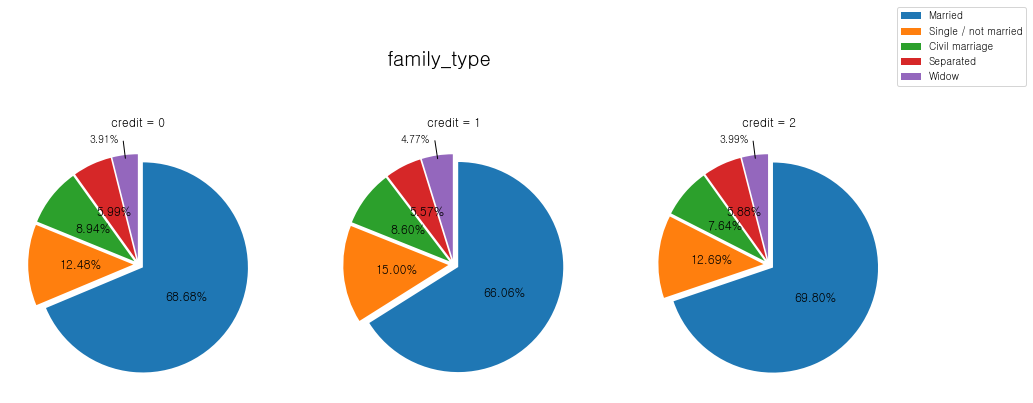

In [29]:
ratio_pie(ratio_by_group(obj_cols[5]), obj_cols[5])

- 모든 신용등급에서 결혼 여부의 순위가 같았습니다.
- 그나마 차이가 있다는 점을 꼽자면, 신용등급이 2인 경우에 Civil marriage (사실혼)의 비율이 낮습니다.

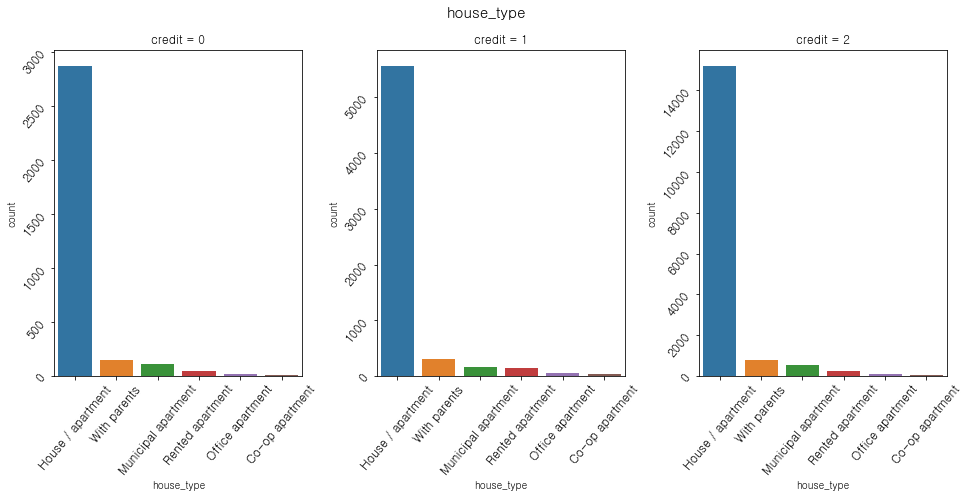

In [30]:
cat_plot(obj_cols[6])

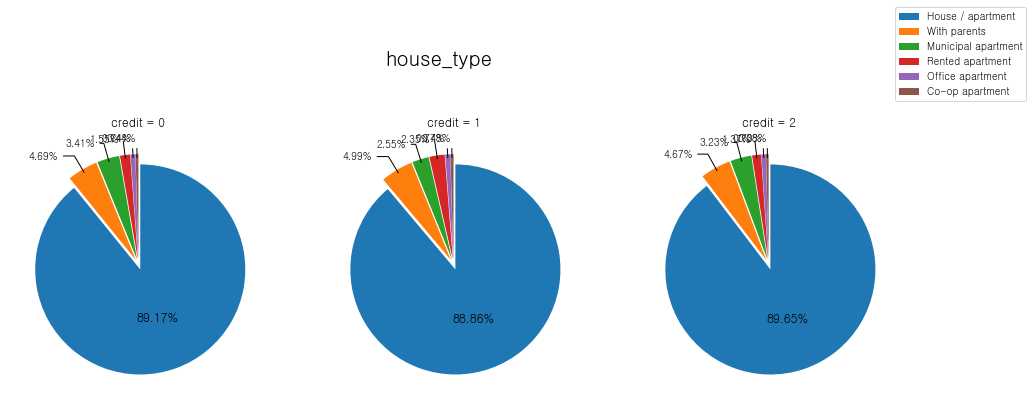

In [31]:
ratio_pie(ratio_by_group(obj_cols[6]), obj_cols[6])

In [32]:
ratio_by_group(obj_cols[6])

,index,house_type,ratio,type
0,House / apartment,2873,0.891682,0
1,With parents,151,0.046865,0
2,Municipal apartment,110,0.034140,0
3,Rented apartment,50,0.015518,0
4,Office apartment,24,0.007449,0
5,Co-op apartment,14,0.004345,0
0,House / apartment,5569,0.888623,1
1,With parents,313,0.049944,1
2,Municipal apartment,160,0.025531,1
3,Rented apartment,147,0.023456,1


- 모든 신용등급에서 생활방식의 순위가 같았습니다.

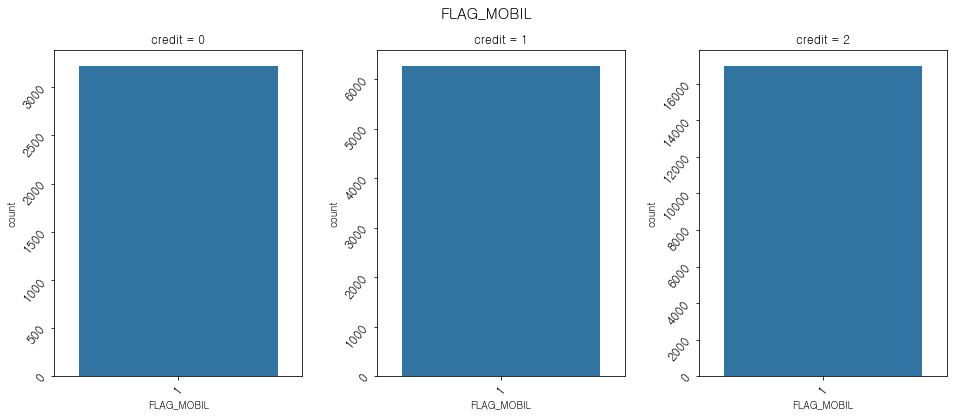

In [33]:
cat_plot('FLAG_MOBIL')

- 모든 사람들이 개인 휴대폰을 소지합니다.
- 이는 모두 같은 값을 가지므로 삭제해도 될 변수인거 같습니다.

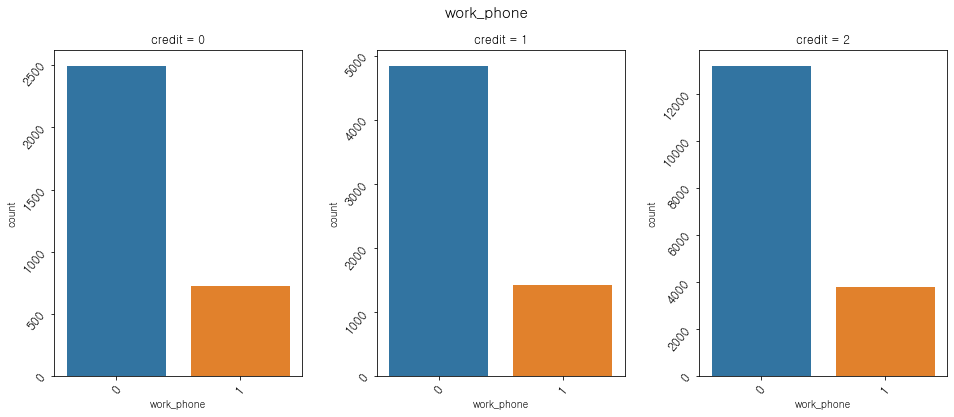

In [34]:
cat_plot('work_phone')

- 모든 신용등급에서 업무용 전화를 소유하고 있는 사람이 더 작습니다.

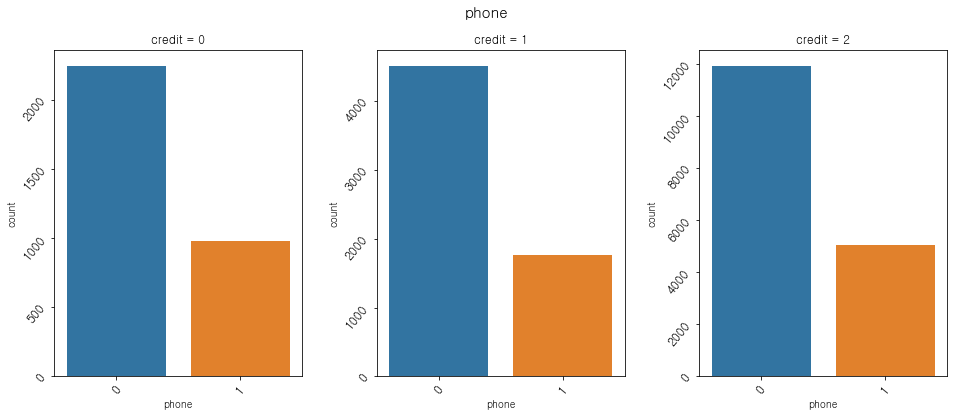

In [35]:
cat_plot('phone')

- 모든 신용등급에서 전화를 소유하고 있는 사람이 더 작습니다.
- 개인 휴대폰이 있기 때문에 이러한 현상이 발생된다고 생각합니다.

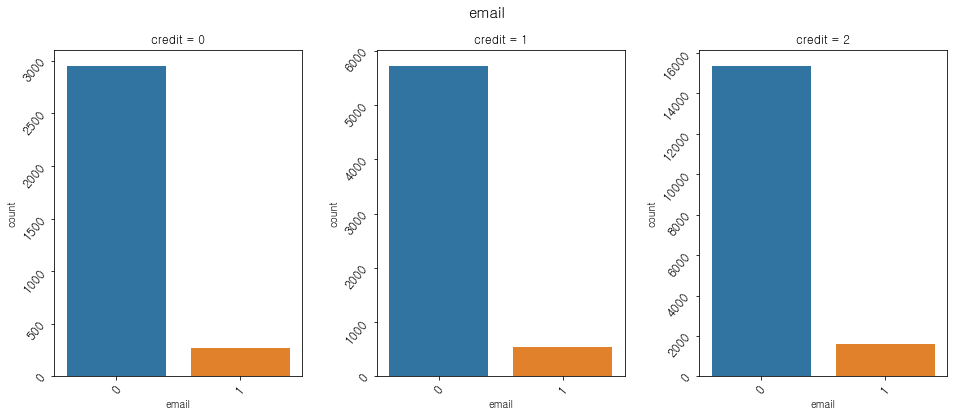

In [36]:
cat_plot('email')

- 모든 신용등급에서 이메일을 소유하고 있는 사람이 더 작습니다.

## 연속형 변수에 대한 EDA

In [37]:
from collections import OrderedDict

def num_plot(column):
    colors = OrderedDict({0 : 'red', 1 : 'blue', 2 : 'green'})
    credit_mapping = OrderedDict({0.0 : 'Excellent', 1.0 : 'Good', 2.0 : 'Normal'})
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    for credit_level, color in colors.items():
        sns.kdeplot(df_train.loc[df_train['credit'] == credit_level, column].dropna(), color = color, label = credit_mapping[credit_level])
        
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        
    plt.suptitle(f'{column.capitalize()} Distribution');
    plt.show()

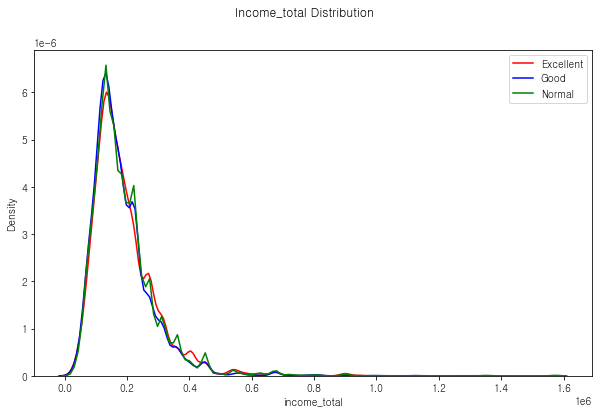

In [38]:
num_plot('income_total')

- 신용등급에 따른 연간 소득 차이는 없어보입니다.

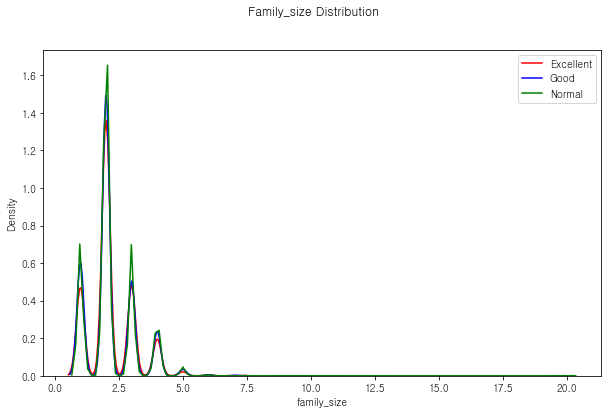

In [39]:
num_plot('family_size')

- 신용등급별 가족 규모에 대해서도 큰 차이가 없어보이지만, 히스토그램을 볼 때, 10 이상의 분포도 존재해보입니다.

In [40]:
df_train['family_size'].describe() # maximum 값이 20이다.

count    26457.000000
mean         2.196848
std          0.916717
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: family_size, dtype: float64

In [41]:
# 나이 변수 생성
df_train['Age'] = abs(df_train['DAYS_BIRTH'] // 365)

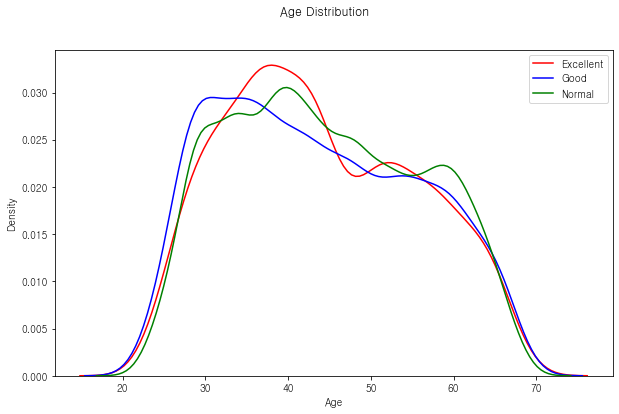

In [42]:
num_plot('Age')

- 큰 차이는 없어보이지만, 신용등급이 좋은 사용자 그룹에서 20~30대 비중이 다른 곳 보다 낮고, 30대 후반 ~ 40대 중반의 사용자들이 다른 분포에 비해 많습니다.
- 나이 변수가 신용등급에 영향을 미치는 것 같아보여서 관련된 변수들을 생성한다면, 모델의 성능을 향상할 수 있다고 생각합니다.

In [43]:
# 업무 기간
df_train['EMPLOYED_year'] = abs(df_train['DAYS_EMPLOYED'].map(lambda x : 0 if x > 0 else x))

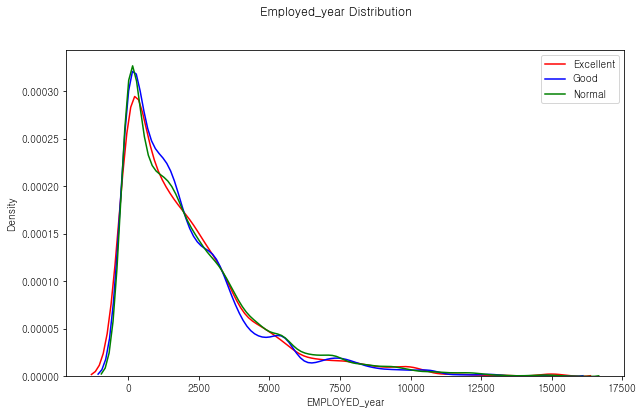

In [44]:
num_plot('EMPLOYED_year')

- 신용등급별로 업무 기간의 차이는 크게 보이지 않습니다.
- 직업이 없는 사람이 대부분을 많은 것을 볼 수 있습니다.

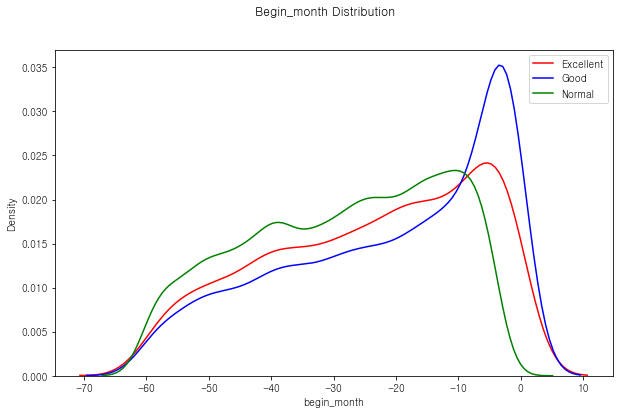

In [45]:
num_plot('begin_month')

- 신용등급이 낮을수록 신용카드를 발급받은지가 오래된 사람이 많습니다.

# 변수 생성 및 전처리   
   
제가 원래 생각했던 컨셉은 아래와 같습니다.   
사용자의 재산을 나타내는 변수들이 있다면, 재산이 많을수록 연체가 덜 되지 않을까? 라는 생각을 했습니다.   
예를 들어, 집의 종류와 부동산 소유 여부등의 범주형 변수들을 합쳐서 새로운 변수를 생성한다면, GBDT 모델이 이들을 더 잘 구분해줄 것이라고 생각했습니다.   
   
데이콘 플랫폼 내의 Byeongtae Park 님의 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent 를 참조하여, Date를 처리했고 모델 성능의 향상을 입증했습니다.   

## 범주형 변수 생성 및 전처리

In [46]:
df_train = train_raw.copy()
df_train.drop(['index'], axis=1, inplace=True)

df_test = test_raw.copy()
df_test.drop(['index'], axis=1, inplace=True)

# 결측값 처리
df_train.loc[df_train['occyp_type'].isnull(), 'occyp_type'] = 'no_job'
df_test.loc[df_test['occyp_type'].isnull(), 'occyp_type'] = 'no_job'

- 개인 소유물에 대해 변수를 생성
- 집의 종류와 부동산 소유를 구분하는 변수를 합치게 되므로써 조금 더 세세하게 재산을 구분해준다고 생각했습니다.
- 차와 부동산을 모두 소유하고 있는 사람은 재산이 많으므로 연체를 덜 하지 않을까라는 생각했습니다.
- 개인 휴대폰, 업무용 전화, 가정 전화, 이메일을 모두 합친 변수를 생성하여, 더 세세하게 재산을 구분해준다고 생각했습니다.

In [47]:
df_train['house_type+reality'] = df_train['house_type'] + df_train['reality']  # 집 형태와 부동산 소유여부를 동시에 나타냄

In [48]:
df_test['house_type+reality'] = df_test['house_type'] + df_test['reality'] # 집 형태와 부동산 소유여부를 동시에 나타냄

In [49]:
df_train['car+reality'] = df_train['car'] + df_train['reality'] # 차와 부동산 소유 여부
df_train['electronics'] = df_train['FLAG_MOBIL'] + df_train['work_phone'] + df_train['phone'] + df_train['email'] # 전자기기 모음

In [50]:
df_test['car+reality'] = df_test['car'] + df_test['reality'] # 차와 부동산 소유 여부
df_test['electronics'] = df_test['FLAG_MOBIL'] + df_test['work_phone'] + df_test['phone'] + df_test['email'] # 전자기기 모음

## 연속형 변수 생성 및 전처리

- 업무시작일이 양수인 경우는 고용되지 않은 상태를 의미하므로 0으로 처리했습니다.

In [51]:
df_train.loc[df_train['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0
df_test.loc[df_test['DAYS_EMPLOYED'] > 0, 'DAYS_EMPLOYED'] = 0

- 음수인 값들을 양수로 바꿔준다.

In [52]:
cols = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
for col in cols:
    df_train[col] = np.abs(df_train[col])
    df_test[col] = np.abs(df_test[col])

- 날짜 변수인 출생일과 업무 시작일을 월, 주로 나누어 변수들을 생성해주었습니다.

In [54]:
# Train Data에 대한 파생변수 생성
# DAYS_BIRTH
df_train['Age'] = df_train['DAYS_BIRTH'] // 365 # 나이
df_train['DAYS_BIRTH_month']=np.floor((df_train['DAYS_BIRTH'])/30)-((np.floor((df_train['DAYS_BIRTH'])/30)/12).astype(int)*12) # 태어난 월
df_train['DAYS_BIRTH_week']=np.floor((df_train['DAYS_BIRTH'])/7)-((np.floor((df_train['DAYS_BIRTH'])/7)/4).astype(int)*4) # 태어난 주

# DAYS_EMPLOYED
df_train['EMPLOYED'] = df_train['DAYS_EMPLOYED'] // 365 # 근속연수
df_train['DAYS_EMPLOYED_month']=np.floor((df_train['DAYS_EMPLOYED'])/30)-((np.floor((df_train['DAYS_EMPLOYED'])/30)/12).astype(int)*12) # 고용된 달
df_train['DAYS_EMPLOYED_week']=np.floor((df_train['DAYS_EMPLOYED'])/7)-((np.floor((df_train['DAYS_EMPLOYED'])/7)/4).astype(int)*4) # 고용된 주

# before_EMPLOYED
df_train['before_EMPLOYED']=df_train['DAYS_BIRTH']-df_train['DAYS_EMPLOYED'] # 고용되기 전까지의 일수
df_train['before_EMPLOYED_month']=np.floor((df_train['before_EMPLOYED'])/30)-((np.floor((df_train['before_EMPLOYED'])/30)/12).astype(int)*12) # 고용되기 전까지의 달
df_train['before_EMPLOYED_week']=np.floor((df_train['before_EMPLOYED'])/7)-((np.floor((df_train['before_EMPLOYED'])/7)/4).astype(int)*4) # 고용되기 전까지의 주

In [55]:
# Test Data에 대한 파생변수 생성
# DAYS_BIRTH
df_test['Age'] = df_test['DAYS_BIRTH'] // 365 # 나이
df_test['DAYS_BIRTH_month']=np.floor((df_test['DAYS_BIRTH'])/30)-((np.floor((df_test['DAYS_BIRTH'])/30)/12).astype(int)*12) # 태어난 달
df_test['DAYS_BIRTH_week']=np.floor((df_test['DAYS_BIRTH'])/7)-((np.floor((df_test['DAYS_BIRTH'])/7)/4).astype(int)*4) # 태어난 주

# DAYS_EMPLOYED
df_test['EMPLOYED'] = df_train['DAYS_EMPLOYED'] // 365 # 근속 연수
df_test['DAYS_EMPLOYED_month']=np.floor((df_test['DAYS_EMPLOYED'])/30)-((np.floor((df_test['DAYS_EMPLOYED'])/30)/12).astype(int)*12) # 고용된 달
df_test['DAYS_EMPLOYED_week']=np.floor((df_test['DAYS_EMPLOYED'])/7)-((np.floor((df_test['DAYS_EMPLOYED'])/7)/4).astype(int)*4) # 고용된 주

df_test['before_EMPLOYED']=df_test['DAYS_BIRTH']-df_test['DAYS_EMPLOYED'] # 고용되기 전까지의 일 수
df_test['before_EMPLOYED_month']=np.floor((df_test['before_EMPLOYED'])/30)-((np.floor((df_test['before_EMPLOYED'])/30)/12).astype(int)*12) # 고용되기 전까지의 달
df_test['before_EMPLOYED_week']=np.floor((df_test['before_EMPLOYED'])/7)-((np.floor((df_test['before_EMPLOYED'])/7)/4).astype(int)*4) # 고용되기 전까지의 주

## 중복 데이터 처리   

In [56]:
cols = ['gender', 'income_total', 'income_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
train_raw[train_raw[cols].duplicated()].shape # 17730 건의 중복 데이터가 존재합니다.

(17730, 20)

데이터를 살펴보았을 때, 성별, 수입, 출생일, 업무 시작일 등이 모두 같은 데이터들이 17,730 건 존재했습니다.   
이는 한 사람이 카드를 여러 번 발급 받았을 것이라고 생각되고 고유한 카드 사용자를 구분지어주는 변수를 생성해야한다고 생각했습니다.

In [57]:
# 성별, 연간 소득, 소득 분류, 출생일, 업무 시작일의 변수를 하나로 만들어 줌 (추후 동일 인물 파악에 사용)

df_train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(df_train['gender'],df_train['income_total'],df_train['income_type'],df_train['DAYS_BIRTH'],df_train['DAYS_EMPLOYED'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(df_train['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(df_train['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 3209명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 5518명


In [58]:
# 성별, 연간 소득, 소득 분류, 출생일, 업무 시작일의 변수를 하나로 만들어 줌 (추후 동일 인물 파악에 사용)

df_test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) for i,j,k,l,m in zip(df_test['gender'],df_test['income_total'],df_test['income_type'],df_test['DAYS_BIRTH'],df_test['DAYS_EMPLOYED'])]

print(f"test set 중복데이터가 아닌 사람의 수 : {sum(df_test['identity'].value_counts()==1)}명")
print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(df_test['identity'].value_counts()>=2)}명")
print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(df_test['identity'].value_counts()>=2)}명")

test set 중복데이터가 아닌 사람의 수 : 3103명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 2468명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 2468명


## 통계량 생성

- 신용등급이 낮을수록 카드 사용자의 카드 발급일이 오래된 것을 보아서 고유 사용자별로 이들을 구분해주는 변수를 생성하려 합니다.
- 고유 사용자 별로 카드 발급월의 평균과 카드를 몇 번 발급 받았는지 등을 구분해주는 통계량들을 생성해봅시다.
- 고유 사용자 별로 카드 발급을 얼마만큼의 주기를 두고 받았는지를 구분해주는 변수도 생성해보고 유의미한 차이가 있는지 살펴봅시다.

In [59]:
range_ = lambda x : x.max() - x.min()
range_.__name__ = 'range_'

train_agg = df_train.groupby(['identity'], as_index=False)['begin_month'].agg(['min', 'max', 'mean', 'std', 'median', range_])

new_col = []
for c in train_agg.columns:
    new_col.append(f'begin_month-{c}')

train_agg.columns = new_col
train_agg = train_agg.reset_index()

df_train = pd.merge(left=df_train, right=train_agg, how='left', on = 'identity')
df_train.loc[df_train['begin_month-std'].isnull(), 'begin_month-std'] = 0 # 고유 사용자의 데이터가 1개라 분산을 0으로 대체해줍니다.

In [60]:
test_agg = df_test.groupby(['identity'], as_index=False)['begin_month'].agg(['min', 'max', 'mean', 'std', 'median', range_])

new_col = []
for c in test_agg.columns:
    new_col.append(f'begin_month-{c}')

test_agg.columns = new_col
test_agg = test_agg.reset_index()

df_test = pd.merge(left=df_test, right=test_agg, how='left', on = 'identity')
df_test.loc[df_test['begin_month-std'].isnull(), 'begin_month-std'] = 0

# 데이터 준비 및 스케일링

In [61]:
cat_cols = list(df_train.select_dtypes('object').columns)
num_cols = list(df_train.select_dtypes('int64').columns) + list(df_train.select_dtypes('float').columns)
num_cols.remove('credit')

display('category columns : ',cat_cols)
print('-'*60)
display('numeric columns : ',num_cols)

'category columns : '

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'house_type+reality',
 'car+reality',
 'identity']

------------------------------------------------------------


'numeric columns : '

['child_num',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'work_phone',
 'phone',
 'email',
 'electronics',
 'Age',
 'EMPLOYED',
 'before_EMPLOYED',
 'income_total',
 'family_size',
 'begin_month',
 'DAYS_BIRTH_month',
 'DAYS_BIRTH_week',
 'DAYS_EMPLOYED_month',
 'DAYS_EMPLOYED_week',
 'before_EMPLOYED_month',
 'before_EMPLOYED_week',
 'begin_month-min',
 'begin_month-max',
 'begin_month-mean',
 'begin_month-std',
 'begin_month-median',
 'begin_month-range_']

In [62]:
df_train_edited = df_train.copy()
df_test_edited = df_test.copy()

In [63]:
encoder = OrdinalEncoder(cat_cols)
df_train_edited[cat_cols] = encoder.fit_transform(df_train_edited[cat_cols], df_train_edited['credit'])
df_test_edited[cat_cols] = encoder.transform(df_test_edited[cat_cols])

df_train_edited['identity'] = df_train_edited['identity'].astype('int64')
df_test_edited['identity'] = df_test_edited['identity'].astype('int64')

In [64]:
scaler = StandardScaler()
df_train_edited[num_cols] = scaler.fit_transform(df_train_edited[num_cols])
df_test_edited[num_cols] = scaler.transform(df_test_edited[num_cols])

In [65]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [66]:
X = df_train_edited.drop(['credit'], axis=1)
y = df_train_edited['credit']
X_test = df_test_edited.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1127)
folds = []

for tr_idx, val_idx in skf.split(X,y):
    folds.append((tr_idx, val_idx))
    
len(folds)

5

In [67]:
y_oof = np.zeros((X.shape[0], 3))
y_preds = np.zeros((X_test.shape[0], 3))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'house_type+reality', 'car+reality']

for fold in range(len(folds)):
    print(f'======={fold}========')
    tr_idx, val_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[tr_idx], X.iloc[val_idx], y.iloc[tr_idx], y.iloc[val_idx]
    
    clf = CatBoostClassifier(n_estimators=2000, random_state=1127)
    clf.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose = 100, cat_features=cat_cols)
    
    y_pred_valid = clf.predict_proba(X_valid)
    y_oof[val_idx] = y_pred_valid
    y_preds += clf.predict_proba(X_test) / 5
    print(f'CV Logloss Score: {log_loss(y_valid, y_pred_valid)}')
    
print(f'Logloss Score: {log_loss(y, y_oof)}')

=======0========
Learning rate set to 0.088074
0:	learn: 1.0489495	test: 1.0493749	best: 1.0493749 (0)	total: 230ms	remaining: 7m 40s
100:	learn: 0.7662069	test: 0.7908003	best: 0.7907944 (99)	total: 6.93s	remaining: 2m 10s
200:	learn: 0.7259359	test: 0.7752609	best: 0.7752609 (200)	total: 13.6s	remaining: 2m 1s
300:	learn: 0.6913045	test: 0.7627084	best: 0.7627008 (299)	total: 20.3s	remaining: 1m 54s
400:	learn: 0.6612292	test: 0.7522078	best: 0.7522078 (400)	total: 27.2s	remaining: 1m 48s
500:	learn: 0.6379898	test: 0.7453236	best: 0.7453236 (500)	total: 33.6s	remaining: 1m 40s
600:	learn: 0.6145884	test: 0.7385550	best: 0.7385550 (600)	total: 40.2s	remaining: 1m 33s
700:	learn: 0.5946542	test: 0.7330612	best: 0.7330330 (699)	total: 47.1s	remaining: 1m 27s
800:	learn: 0.5765166	test: 0.7291235	best: 0.7291235 (800)	total: 53.3s	remaining: 1m 19s
900:	learn: 0.5601819	test: 0.7260687	best: 0.7260687 (900)	total: 59.8s	remaining: 1m 12s
1000:	learn: 0.5446092	test: 0.7233188	best: 0.72

In [68]:
print(f'Logloss Score: {log_loss(y, y_oof)}')

Logloss Score: 0.7121684651718004


In [69]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:, 1:] = y_preds
submission.head()

,index,0,1,2
0,26457,0.080448,0.197891,0.721660
1,26458,0.288932,0.129466,0.581602
2,26459,0.054392,0.116231,0.829377
3,26460,0.223675,0.090372,0.685953
4,26461,0.101025,0.224036,0.674940


In [70]:
submission.to_csv('submission/CB_predict.csv', index=False)

# 변수 중요도 확인

<AxesSubplot:>

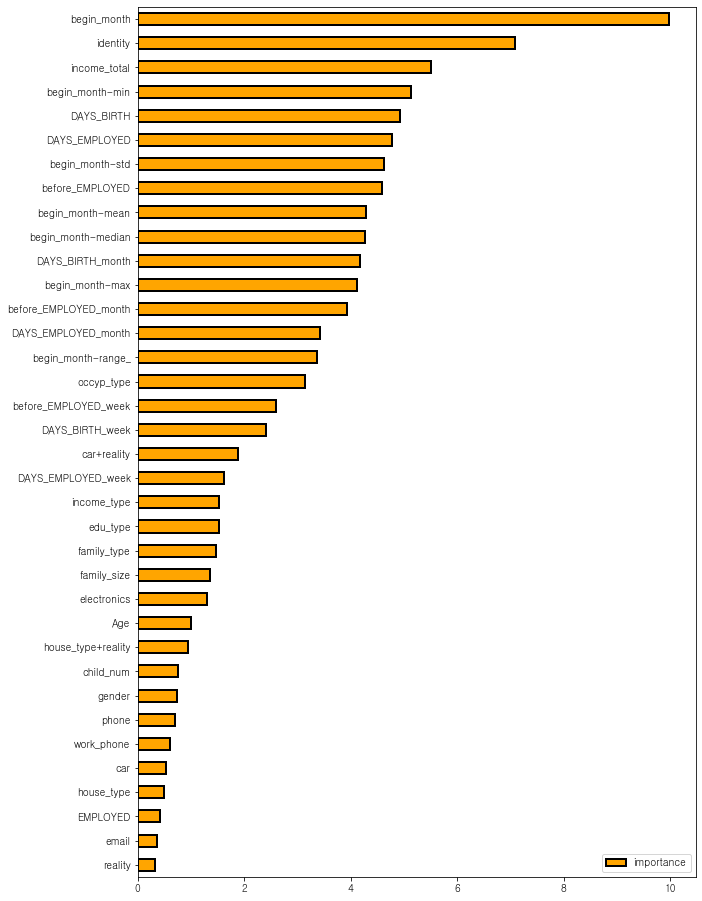

In [71]:
feature_importance_df = pd.DataFrame(clf.feature_importances_,\
                                     index=df_train_edited.drop(['credit'], axis = 1).columns, columns=['importance'])\
.sort_values(by='importance', ascending=True)

pd.set_option('max_rows', 100)
feature_importance_df[feature_importance_df['importance'] > 0].plot.barh(figsize = (10,16), color = 'orange', edgecolor = 'k', linewidth = 2)

- identity (고유 사용자 확인 변수)가 모델에 높은 영향을 미치는 것을 볼 수 있습니다.
- 이외에도 새로 생성한 통계량들이 영향을 미치는 것도 볼 수 있습니다.

## 변수 선택 및 최종제출

In [72]:
non_imp_feat = list(feature_importance_df[feature_importance_df['importance'] <= 0].index)
display(non_imp_feat)
df_train_edited = df_train_edited.drop(non_imp_feat, axis=1)
df_test_edited = df_test_edited.drop(non_imp_feat, axis=1)

['FLAG_MOBIL']

In [73]:
imp_Q3 = np.quantile(feature_importance_df, 0.25)
down_Q3_feat = list(feature_importance_df[feature_importance_df['importance'] <= imp_Q3].index)
df_train_edited = df_train_edited.drop(list(set(down_Q3_feat) - set(non_imp_feat)), axis=1)
df_test_edited = df_test_edited.drop(list(set(down_Q3_feat) - set(non_imp_feat)), axis=1)

In [74]:
X = df_train_edited.drop(['credit'], axis=1)
y = df_train_edited['credit']
X_test = df_test_edited.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1127)
folds = []

for tr_idx, val_idx in skf.split(X,y):
    folds.append((tr_idx, val_idx))
    
len(folds)

5

In [75]:
y_oof = np.zeros((X.shape[0], 3))
y_preds = np.zeros((X_test.shape[0], 3))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type+reality', 'car+reality']

for fold in range(len(folds)):
    print(f'======={fold}========')
    tr_idx, val_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[tr_idx], X.iloc[val_idx], y.iloc[tr_idx], y.iloc[val_idx]
    
    clf = CatBoostClassifier(n_estimators=2000, random_state=1127)
    clf.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose = 100, cat_features=cat_cols)
    
    y_pred_valid = clf.predict_proba(X_valid)
    y_oof[val_idx] = y_pred_valid
    y_preds += clf.predict_proba(X_test) / 5
    print(f'CV Logloss Score: {log_loss(y_valid, y_pred_valid)}')
    
print(f'Logloss Score: {log_loss(y, y_oof)}')

=======0========
Learning rate set to 0.088074
0:	learn: 1.0487991	test: 1.0491372	best: 1.0491372 (0)	total: 43.6ms	remaining: 1m 27s
100:	learn: 0.7641582	test: 0.7891400	best: 0.7891400 (100)	total: 4.67s	remaining: 1m 27s
200:	learn: 0.7223385	test: 0.7727842	best: 0.7727842 (200)	total: 9.38s	remaining: 1m 23s
300:	learn: 0.6877778	test: 0.7609162	best: 0.7609162 (300)	total: 13.9s	remaining: 1m 18s
400:	learn: 0.6603442	test: 0.7523652	best: 0.7523652 (400)	total: 18.5s	remaining: 1m 13s
500:	learn: 0.6357844	test: 0.7472695	best: 0.7472695 (500)	total: 23.2s	remaining: 1m 9s
600:	learn: 0.6128184	test: 0.7419481	best: 0.7417946 (595)	total: 28s	remaining: 1m 5s
700:	learn: 0.5938267	test: 0.7372884	best: 0.7372884 (700)	total: 32.8s	remaining: 1m
800:	learn: 0.5755511	test: 0.7329125	best: 0.7328990 (799)	total: 37.5s	remaining: 56.2s
900:	learn: 0.5587099	test: 0.7295213	best: 0.7295046 (899)	total: 42.1s	remaining: 51.3s
1000:	learn: 0.5433679	test: 0.7258241	best: 0.7258241 (

In [76]:
print(f'Logloss Score: {log_loss(y, y_oof)}')

Logloss Score: 0.7138769312389238


In [77]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:, 1:] = y_preds
submission.head()

,index,0,1,2
0,26457,0.089264,0.158562,0.752174
1,26458,0.241884,0.102985,0.655131
2,26459,0.059335,0.126043,0.814622
3,26460,0.213228,0.074599,0.712174
4,26461,0.144720,0.220467,0.634813


In [78]:
submission.to_csv('submission/CB_predict_final.csv', index=False)